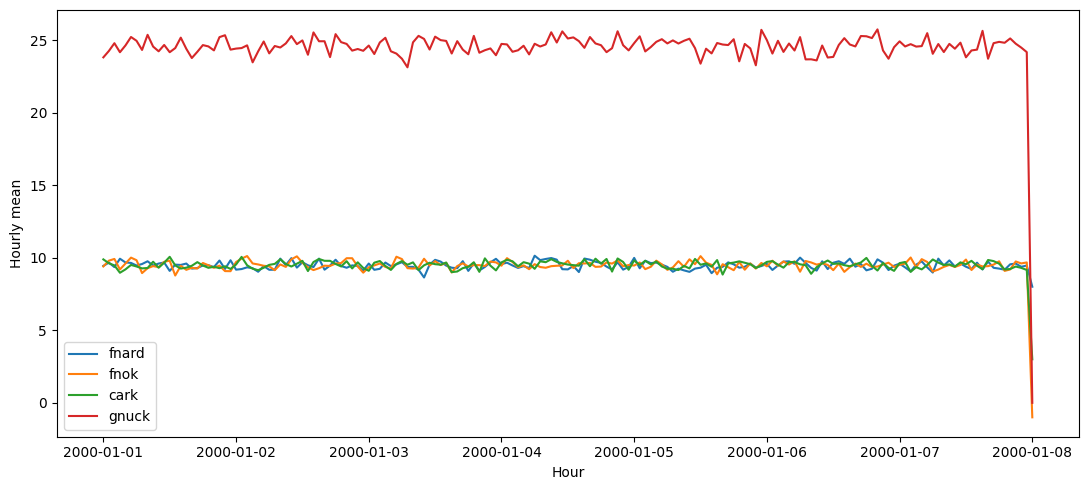

In [ ]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

con = duckdb.connect()
parq = "quazyilx0.parquet"

sql = con.execute("""
WITH hourly AS (
  SELECT
    DATE_TRUNC('hour', date_time) AS hour_ts,
    AVG(fnard) AS fnard,
    AVG(fnok) AS fnok,
    AVG(cark) AS cark,
    AVG(gnuck) AS gnuck
  FROM parquet_scan($parq)
  WHERE date_time >= (SELECT MIN(date_time) FROM parquet_scan($parq))
    AND date_time < (SELECT MIN(date_time) FROM parquet_scan($parq)) + INTERVAL '7 day'
  GROUP BY 1
)
SELECT * FROM hourly ORDER BY hour_ts;
""", {"parq": parq}).df()

plt.figure(figsize=(11,5))
for col in ["fnard","fnok","cark","gnuck"]:
    plt.plot(sql["hour_ts"], sql[col], label=col)
plt.xlabel("Hour")
plt.ylabel("Hourly mean")
plt.legend()
plt.tight_layout()
plt.savefig("hourly_timeseries.png")
plt.show()

In [1]:
moving_avg = con.execute("""
WITH daily AS (
  SELECT
    DATE_TRUNC('day', date_time) AS date,
    AVG(fnard) AS fnard, AVG(fnok) AS fnok,
    AVG(cark) AS cark, AVG(gnuck) AS gnuck
  FROM parquet_scan($parq)
  GROUP BY 1
),
moving_avg AS (
  SELECT
    date, fnard, fnok, cark, gnuck,
    AVG(fnard) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS fnard_ma7,
    AVG(fnok) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS fnok_ma7,
    AVG(cark) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS cark_ma7,
    AVG(gnuck) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS gnuck_ma7
  FROM daily
)
SELECT
  date,
  fnard_ma7, fnok_ma7, cark_ma7, gnuck_ma7,
  /* flag day if any series deviates >50% from its MA (avoid div/0 with NULLIF) */
  ((ABS(fnard - fnard_ma7)/NULLIF(fnard_ma7,0) > 0.5) OR
   (ABS(fnok - fnok_ma7) /NULLIF(fnok_ma7,0) > 0.5) OR
   (ABS(cark - cark_ma7) /NULLIF(cark_ma7,0) > 0.5) OR
   (ABS(gnuck - gnuck_ma7)/NULLIF(gnuck_ma7,0) > 0.5))::BOOLEAN AS volatility_flag
FROM moving_avg
ORDER BY date;
""", {"parq": parq}).df()

moving_avg.head()

NameError: name 'con' is not defined

In [5]:
corr_row = con.execute("""
WITH daily AS (
  SELECT DATE_TRUNC('day', date_time) AS date,
         AVG(fnard) AS fnard, AVG(fnok) AS fnok,
         AVG(cark) AS cark, AVG(gnuck) AS gnuck
  FROM parquet_scan($parq)
  GROUP BY 1
)
SELECT
  CORR(fnard, fnok) AS corr_fnard_fnok,
  CORR(fnard, cark) AS corr_fnard_cark,
  CORR(fnard, gnuck) AS corr_fnard_gnuck,
  CORR(fnok, cark) AS corr_fnok_cark,
  CORR(fnok, gnuck) AS corr_fnok_gnuck,
  CORR(cark, gnuck) AS corr_cark_gnuck
FROM daily;
""", {"parq": parq}).df().iloc[0].to_dict()

mat = pd.DataFrame(
    [
        [1, corr_row['corr_fnard_fnok'], corr_row['corr_fnard_cark'], corr_row['corr_fnard_gnuck']],
        [corr_row['corr_fnard_fnok'], 1, corr_row['corr_fnok_cark'], corr_row['corr_fnok_gnuck']],
        [corr_row['corr_fnard_cark'], corr_row['corr_fnok_cark'], 1, corr_row['corr_cark_gnuck']],
        [corr_row['corr_fnard_gnuck'], corr_row['corr_fnok_gnuck'], corr_row['corr_cark_gnuck'], 1],
    ],
    index=["fnard","fnok","cark","gnuck"],
    columns=["fnard","fnok","cark","gnuck"]
)
mat.to_csv("measurement_correlations.csv")
mat.head()

,fnard,fnok,cark,gnuck
fnard,1.000000,0.035275,0.080946,-0.059726
fnok,0.035275,1.000000,-0.011025,0.038231
cark,0.080946,-0.011025,1.000000,0.084474
gnuck,-0.059726,0.038231,0.084474,1.000000


In [9]:
patterns = con.execute("""
WITH base AS (
  SELECT * FROM parquet_scan($parq)
),
hourly AS (
  SELECT EXTRACT(hour FROM date_time)::INT AS hour,
                       AVG(fnard) AS fnard_avg,
                       AVG(fnok) AS fnok_avg,
                       AVG(cark) AS cark_avg,
                       AVG(gnuck) AS gnuck_avg
  FROM base
  GROUP BY 1
),
daily AS (
  SELECT DATE_TRUNC('day', date_time) AS day,
                       AVG(fnard) AS fnard,
                       AVG(fnok) AS fnok,
                       AVG(cark) AS cark,         
                       AVG(gnuck) AS gnuck
  FROM base
  GROUP BY 1
),
thresh AS (
  SELECT
    quantile(fnard, 0.9) AS t_fnard,
    quantile(fnok, 0.9) AS t_fnok,
    quantile(cark, 0.9) AS t_cark,
    quantile(gnuck, 0.9) AS t_gnuck
  FROM daily
),
peaks AS (
  SELECT d.day
  FROM daily d, thresh t
  WHERE d.fnard >= t.t_fnard
    AND d.fnok >= t.t_fnok
    AND d.cark >= t.t_cark
    AND d.gnuck >= t.t_gnuck
),
business_hours AS (
  SELECT
    100.0 * SUM(CASE WHEN EXTRACT(hour FROM date_time) BETWEEN 9 AND 17 THEN 1 ELSE 0 END) / COUNT(*) AS pct_business_hours
  FROM base
)
SELECT
  (SELECT hour FROM hourly ORDER BY fnard_avg DESC LIMIT 1) AS hour_max_fnard,
  (SELECT hour FROM hourly ORDER BY fnok_avg DESC LIMIT 1) AS hour_max_fnok,
  (SELECT hour FROM hourly ORDER BY cark_avg DESC LIMIT 1) AS hour_max_cark,
  (SELECT hour FROM hourly ORDER BY gnuck_avg DESC LIMIT 1) AS hour_max_gnuck,
  (SELECT STRING_AGG(CAST(day AS VARCHAR), ',') FROM peaks) AS all_four_peaks_days,
  (SELECT pct_business_hours FROM business_hours) AS pct_business_hours;
""", {"parq": parq}).df()

patterns.to_csv("time_patterns.csv", index=False)
patterns.head()

,hour_max_fnard,hour_max_fnok,hour_max_cark,hour_max_gnuck,all_four_peaks_days,pct_business_hours
0,17,5,17,19,None,37.4694
